In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

def N_Gaussian(x, mu, sigma):
    X = np.matrix(x).T
    mu = np.matrix(mu).T
    sigma = np.matrix(sigma)

    x_mu = X - mu

    w1 = np.matmul(np.linalg.inv(sigma), x_mu)
    w2 = -0.5 * np.matmul(x_mu.T, w1)

    det = np.linalg.det(sigma)

    N = 1/(np.sqrt(((2*np.pi)**len(x)) * np.abs(det))) * np.exp(w2)
    return N[0,0]

def box_muller(n):
    r1 = np.random.rand(n)
    r2 = np.random.rand(n)

    x = np.sqrt(-2*np.log(r1)) * np.sin(2*np.pi*r2)
    return x

def sampling_gaus(n, sample, mu, sigma):
    L = np.linalg.cholesky(sigma)

    Y = np.array([np.dot(L, box_muller(n)) for _ in range(sample)]) + mu
    return Y

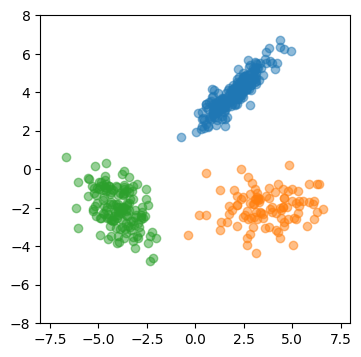

In [449]:
import matplotlib.pyplot as plt

data1 = sampling_gaus(2, 200, [2,4], [[1, 0.9], [0.9,1]])
data2 = sampling_gaus(2, 100, [4,-2], [[2, 0.1], [0.1,1]])
data3 = sampling_gaus(2, 150, [-4,-2], [[1, -0.5], [-0.5,1]])


x = np.concatenate([data1, data2, data3])
y = np.array([0]*200+[1]*100+[2]*150)

plt.figure(figsize=(4,4))
plt.scatter(data1[:,0], data1[:,1], alpha=.5);
plt.scatter(data2[:,0], data2[:,1], alpha=.5);
plt.scatter(data3[:,0], data3[:,1], alpha=.5);
plt.xlim(-8, 8);
plt.ylim(-8, 8);

In [599]:
arr = np.arange(450)
np.random.shuffle(arr)
y_pred = np.zeros(450)

K = 3
dim = 2
T = 451

# 時刻ごとの値を保存させる
pi_tilde = np.zeros([T, K, 1, 1])
mu_tilde = np.zeros([T, K, dim, 1])
S_tilde = np.zeros([T, K, dim, dim])

q = np.zeros_like(pi_tilde)
pi = np.zeros_like(pi_tilde)
mu = np.zeros_like(mu_tilde)
S = np.zeros_like(S_tilde)

beta = 0.1
gamma = 5

# 初期値の設定
q[0] = np.ones_like(pi_tilde[0])/K
pi_tilde[0] = np.ones_like(pi_tilde[0])/K
mu_tilde[0] = np.random.normal(0,8,size=(3,2,1))
S_tilde[0][:,0,1] = S_tilde[0][:,1,0] = np.random.normal(0,1,size=3)
S_tilde[0][:,0,0] = S_tilde[0][:,1,1] = np.random.normal(0,1,size=3)

def update_params(beta, x, q, t):
    x = x.reshape(-1,1)
    pi_tilde_new = (1-beta)*pi_tilde[t-1] + beta*q[t]
    mu_tilde_new = (1-beta)*mu_tilde[t-1] + beta*q[t]*x
    S_tilde_new  = (1-beta)*S_tilde[t-1]  + beta*q[t]*np.tile(x@x.T, (K,1,1))
    return pi_tilde_new, mu_tilde_new, S_tilde_new

def calc_params(pi_tilde, mu_tilde, S_tilde, t):
    pi_new = (pi_tilde[t] + gamma) / (K * gamma + np.sum(pi_tilde[t]))
    mu_new = mu_tilde[t] / pi_tilde[t]
    S_new  = S_tilde[t] / pi_tilde[t]-mu_new@mu_new.transpose(0,2,1)
    return pi_new, mu_new, S_new

def calc_q(x, pi, mu, S, t):
    p = np.zeros((K,1,1))
    for i in np.arange(K):
        g = N_Gaussian(x, mu=mu[t][i].T, sigma=S[t][i])
        p[i] = pi[t,i]*g
    return p / np.sum(p)

def calc_q2(x, pi, mu, S, t):
    p = np.zeros((K,1,1))
    for i in np.arange(K):
        g = N_Gaussian(x, mu=mu[t][i].T, sigma=S[t][i])
        p[i] = g
    return p

pi[0], mu[0], S[0] = calc_params(pi_tilde, mu_tilde, S_tilde, t=0)
for t in np.arange(1,T):
    xi = x[arr[t-1]]
    
    q[t] = calc_q(xi, pi, mu, S, t=t-1)
    pi_tilde[t], mu_tilde[t], S_tilde[t] = update_params(beta, xi, q, t=t)
    pi[t], mu[t], S[t] = calc_params(pi_tilde, mu_tilde, S_tilde, t=t)
    q[t] = calc_q(xi, pi, mu, S, t=t)
    #pi_tilde[t], mu_tilde[t], S_tilde[t] = pi[t], mu[t], S[t]

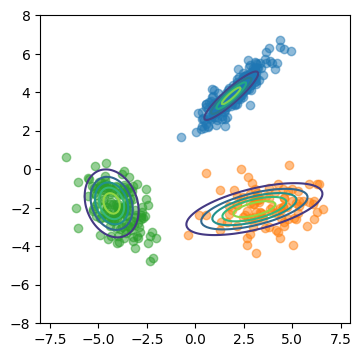

In [600]:
x1 = np.arange(-8,8,0.1)
x2 = np.arange(-8,8,0.1)

xx1, xx2 = np.meshgrid(x1, x2)
xx1=xx1.ravel()
xx2=xx2.ravel()

P=np.array([calc_q2(np.array([x,y]), pi, mu, S, t=T-1)[:,0,0] for x,y in zip(xx1,xx2)])
P[P < 1e-150]=1e-150

plt.figure(figsize=(4,4))
for k in range(3):
    plt.contour(xx1.reshape(len(x1),len(x1)),xx2.reshape(len(x1),len(x1)),P[:,k].reshape(len(x1),len(x1)),levels=5)
plt.scatter(data1[:,0], data1[:,1], alpha=.5);
plt.scatter(data2[:,0], data2[:,1], alpha=.5);
plt.scatter(data3[:,0], data3[:,1], alpha=.5);
plt.xlim(-8, 8);
plt.ylim(-8, 8);

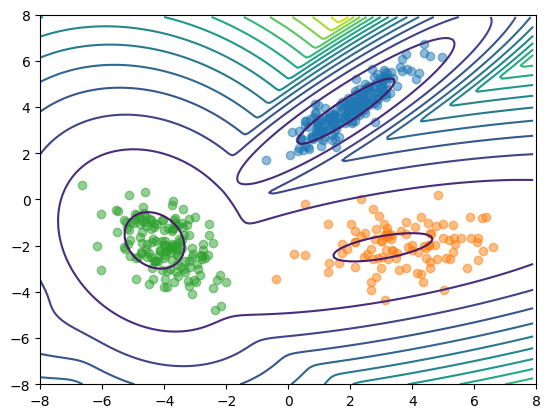

In [632]:
plt.contour(xx1.reshape(len(x1),len(x1)),xx2.reshape(len(x1),len(x1)),-np.log(np.sum(P*pi[-1].reshape(1,3), axis=1) / np.sum(P*pi_tilde[-1].reshape(1,3))).reshape(len(x1),len(x1)), levels=15)
plt.scatter(data1[:,0], data1[:,1], alpha=.5);
plt.scatter(data2[:,0], data2[:,1], alpha=.5);
plt.scatter(data3[:,0], data3[:,1], alpha=.5);
plt.xlim(-8, 8);
plt.ylim(-8, 8);

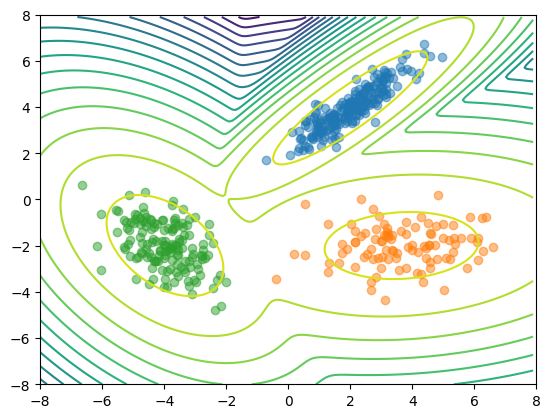

In [634]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=3,
).fit(x)

plt.contour(xx1.reshape(len(x1),len(x1)),xx2.reshape(len(x1),len(x1)),gmm.score_samples(np.array([xx1,xx2]).T).reshape(len(x1), len(x1)), levels=15)
plt.scatter(data1[:,0], data1[:,1], alpha=.5);
plt.scatter(data2[:,0], data2[:,1], alpha=.5);
plt.scatter(data3[:,0], data3[:,1], alpha=.5);
plt.xlim(-8, 8);
plt.ylim(-8, 8);